## Package

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, InceptionV3, VGG16
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


In [2]:
# test gpu
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))
tf.test.is_gpu_available

Num GPUs Available: 2


<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

## Read and Analysis

In [3]:
import pandas as pd

def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [4]:
file_path ='Tomato disease/'
df = loading_the_data(file_path)

df.head()

,filepaths,labels
0,Tomato disease/Bacterial spot disease\Bacteria...,Bacterial spot disease
1,Tomato disease/Bacterial spot disease\Bacteria...,Bacterial spot disease
2,Tomato disease/Bacterial spot disease\Bacteria...,Bacterial spot disease
3,Tomato disease/Bacterial spot disease\Bacteria...,Bacterial spot disease
4,Tomato disease/Bacterial spot disease\Bacteria...,Bacterial spot disease


In [5]:
label_counts = df['labels'].value_counts()
label_counts

labels
Bacterial spot disease                          1000
Early blight disease                            1000
healthy label                                   1000
Late blight disease                             1000
Leaf_Mold disease                               1000
Septoria leaf spot disease                      1000
Spider mites Two-spotted spider mite disease    1000
Target Spot disease                             1000
Tomato mosaic virus disease                     1000
Yellow Leaf Curl Virus disease                  1000
Name: count, dtype: int64

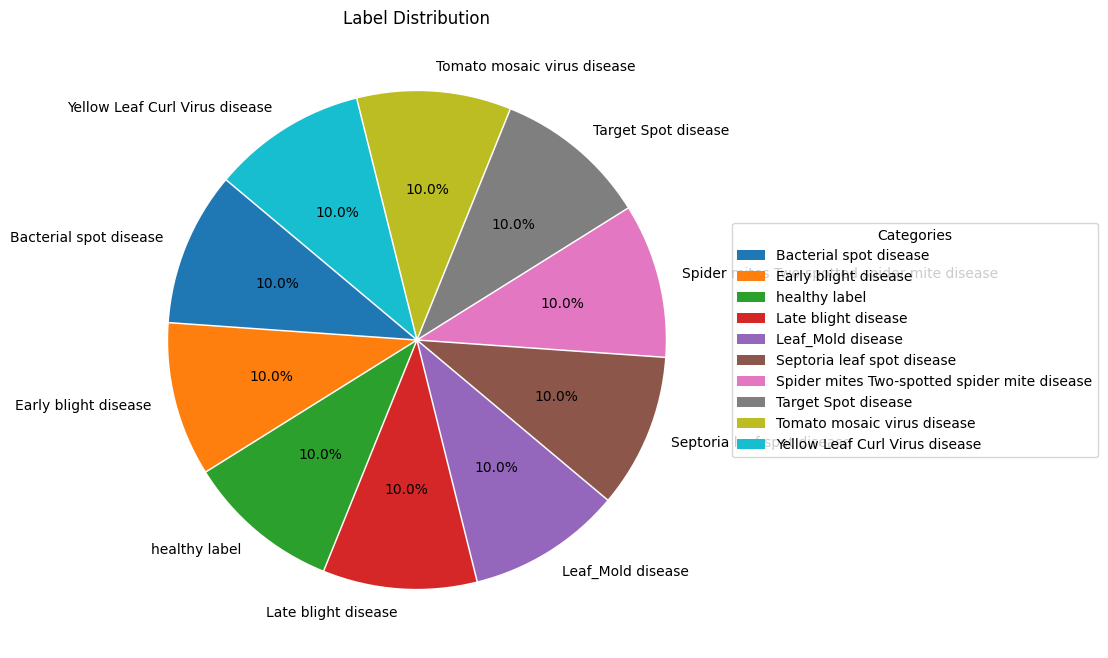

In [6]:
labels = label_counts.index.tolist()
values = label_counts.tolist()
colors = plt.get_cmap('tab10').colors

explode = [0.01]*len(labels)
plt.figure(figsize=(10,8))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)

plt.title("Label Distribution")
plt.legend(title='Categories',loc='center left',bbox_to_anchor=(1,0.5))
plt.show()

## Preprocess and Augment Data

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory(file_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42,
                                             label_mode='categorical')
validation_dataset = image_dataset_from_directory(file_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42,
                                             label_mode='categorical')
train_data = train_dataset.map(lambda x, y: (x / 255.0, y))
val_data = validation_dataset.map(lambda x, y: (x / 255.0, y))

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [8]:
train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

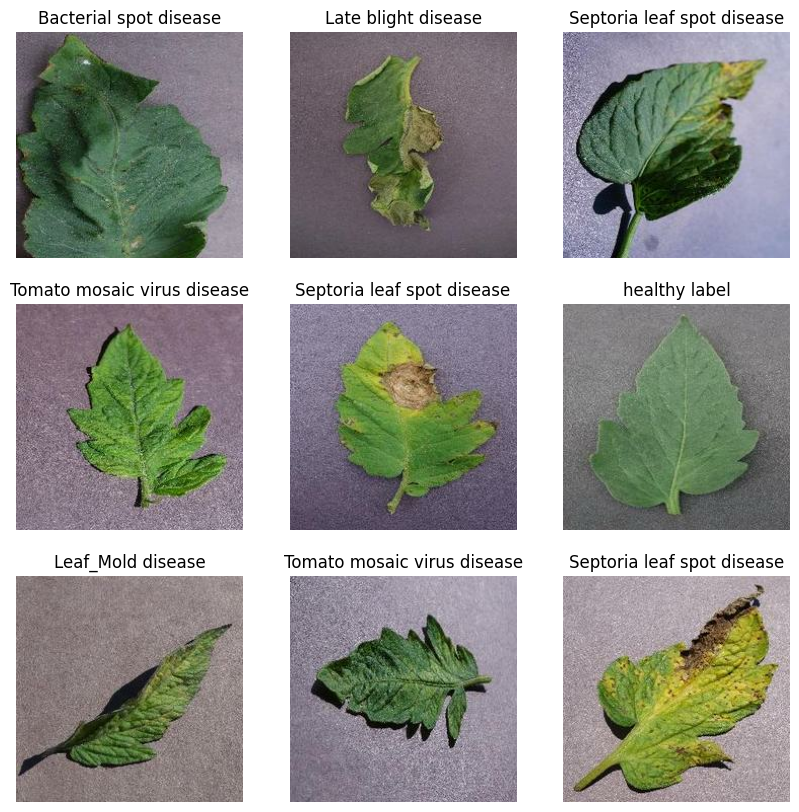

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for image, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis('off')

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [11]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
            RandomFlip('horizontal'),
            RandomRotation(0.2)
    ])
    
    return data_augmentation

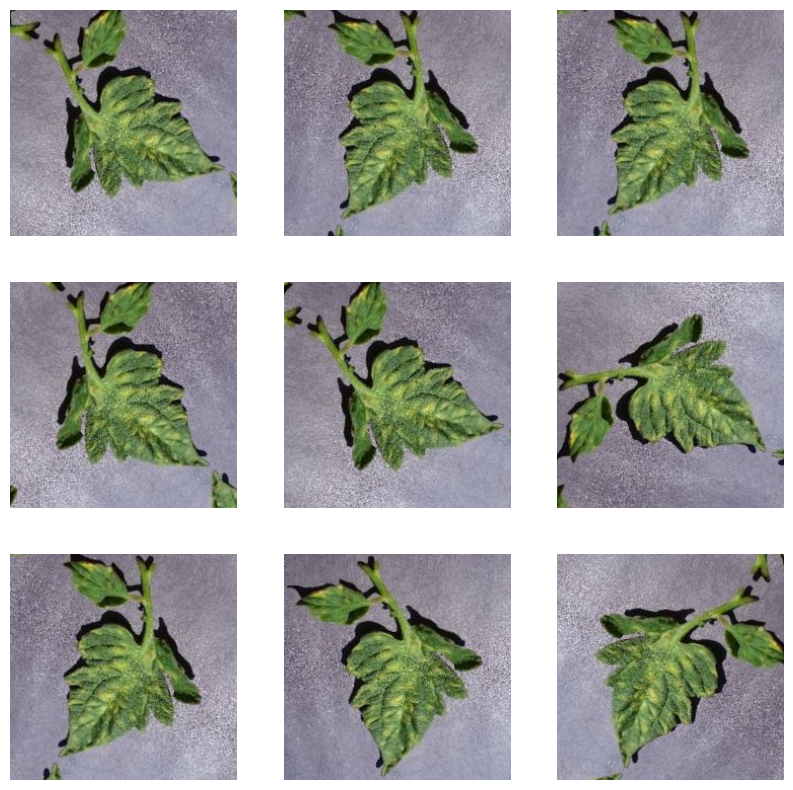

In [12]:
data_augmentation = data_augmenter()

tf.get_logger().setLevel('ERROR')
for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy() / 255)
        plt.axis('off')

## Modeling

In [13]:
def compile_and_train_model(model,optimizer,epochs,train_data=train_data, validation_data=val_data):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data,epochs=epochs, validation_data=validation_data,verbose=1)
    return history

In [14]:
results = []

def find_best_optimizer(model_builder, optimizers, epochs ,train_data=train_data, val_data=val_data):
    '''
    Train a model using different optimizers and return the best configuration based on validation accuracy.

    Args:
    model_builder (function): Function to build the model.
    optimizers (list): List of tensorflow.keras.optimizers instances.
    train_data, val_data (tf.data.Dataset): Training and validation datasets.
    epochs (int): Number of epochs to train each model.
    '''

    best_accuracy = 0
    best_config = None
    best_history = None

    for opt in optimizers:
        print(f"Testing optimizer: {opt.get_config()['name']} with learning rate: {opt.get_config()['learning_rate']}")
        model = model_builder()
        history = compile_and_train_model(model,opt,epochs)

        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_config = opt
            best_history = history

    print(f"Best configuration: {best_config.get_config()['name']} with learning rate: {best_config.get_config()['learning_rate']}")
    
    return best_config,best_history,best_accuracy

In [15]:
optimizers = [Adam(learning_rate=0.0001),
             SGD(learning_rate=0.0001),
             RMSprop(learning_rate=0.0001)]

In [16]:
'''
Assignment Requirement:
The size of your model roughly say just 4 – 6 convolutional and 2 - 3 classification layers.
'''
def create_model(input_shape=IMG_SIZE):
    '''
    image_shape -- Image width and height
    data_augmentation -- data augmentation function
    '''
    input_shape = input_shape + (3,)
    model = Sequential()
    
    # Input layer
    model.add(InputLayer(input_shape=input_shape))
    
    # Data augmentation layer
    model.add(data_augmenter())
    
    # First Conv => Activation => Conv => Activation => Pool layer set
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Conv => Activation => Conv => Activation => Pool layer set
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Conv =>
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    
    # Dense Layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10,activation='softmax'))
    
    return model

In [17]:
my_model = create_model()
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)    

In [18]:
my_model_config, my_model_history, my_model_accuracy = find_best_optimizer(create_model, optimizers, epochs=40)

Testing optimizer: Adam with learning rate: 0.0001
Epoch 1/40
250/250 [==============================] - 35s 135ms/step - loss: 1.4755 - accuracy: 0.5539 - val_loss: 18.2316 - val_accuracy: 0.1465
Epoch 2/40
250/250 [==============================] - 33s 132ms/step - loss: 0.7774 - accuracy: 0.7274 - val_loss: 10.8904 - val_accuracy: 0.2355
Epoch 3/40
250/250 [==============================] - 33s 133ms/step - loss: 0.6142 - accuracy: 0.7909 - val_loss: 1.9976 - val_accuracy: 0.6540
Epoch 4/40
250/250 [==============================] - 33s 133ms/step - loss: 0.5221 - accuracy: 0.8218 - val_loss: 3.3792 - val_accuracy: 0.5435
Epoch 5/40
250/250 [==============================] - 33s 133ms/step - loss: 0.4684 - accuracy: 0.8393 - val_loss: 2.8946 - val_accuracy: 0.5845
Epoch 6/40
250/250 [==============================] - 33s 133ms/step - loss: 0.4068 - accuracy: 0.8588 - val_loss: 3.1095 - val_accuracy: 0.6080
Epoch 7/40
250/250 [==============================] - 34s 137ms/step - loss: 

## Transfer Learning

### VGG16

In [19]:
def vgg_model(image_shape=IMG_SIZE, optimizer=None):
    input_shape = image_shape + (3,)
    conv_base = VGG16(weights='imagenet',
                     include_top=False,
                     input_shape=input_shape,
                     pooling='max')

    for layer in conv_base.layers[:15]:
        layer.trainable=False
        
     # build model
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))  

 
    return model

In [20]:
vgg_m = vgg_model()
vgg_m.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 32)               

In [21]:
vgg_config, vgg_history, vgg_accuracy = find_best_optimizer(vgg_model, optimizers,epochs=20)

Testing optimizer: Adam with learning rate: 9.999999747378752e-05
Epoch 1/20
250/250 [==============================] - 23s 89ms/step - loss: 1.6728 - accuracy: 0.3896 - val_loss: 0.9118 - val_accuracy: 0.6685
Epoch 2/20
250/250 [==============================] - 22s 87ms/step - loss: 0.7133 - accuracy: 0.7556 - val_loss: 0.6154 - val_accuracy: 0.7935
Epoch 3/20
250/250 [==============================] - 22s 87ms/step - loss: 0.3896 - accuracy: 0.8689 - val_loss: 0.3747 - val_accuracy: 0.8825
Epoch 4/20
250/250 [==============================] - 22s 87ms/step - loss: 0.2677 - accuracy: 0.9115 - val_loss: 0.3538 - val_accuracy: 0.8955
Epoch 5/20
250/250 [==============================] - 22s 87ms/step - loss: 0.1703 - accuracy: 0.9433 - val_loss: 0.3002 - val_accuracy: 0.9095
Epoch 6/20
250/250 [==============================] - 23s 94ms/step - loss: 0.1132 - accuracy: 0.9611 - val_loss: 0.2728 - val_accuracy: 0.9210
Epoch 7/20
250/250 [==============================] - 22s 87ms/step - 

### DenseNet121

In [22]:
def DenseNet_model(image_shape=IMG_SIZE):

    input_shape = image_shape + (3,)
    base_model = DenseNet121(
        weights='imagenet',
        include_top = False,
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False
    # build model
    model = Sequential()
    
    # Input layer
    model.add(InputLayer(input_shape=input_shape))
    
    # Data augmentation layer
    # model.add(data_augmenter())
    model.add(base_model)
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.35))
    model.add(BatchNormalization())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

In [23]:
DenseNet_m = DenseNet_model()
DenseNet_m.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_20 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_28 (Dense)            (None, 256)               262400    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_21 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 120)             

In [24]:
DenseNet_config, DenseNet_history, DenseNet_accuracy = find_best_optimizer(DenseNet_model, optimizers, epochs=40)

Testing optimizer: Adam with learning rate: 9.999999747378752e-05
Epoch 1/40
250/250 [==============================] - 17s 57ms/step - loss: 0.9054 - accuracy: 0.6985 - val_loss: 0.5722 - val_accuracy: 0.8575
Epoch 2/40
250/250 [==============================] - 13s 53ms/step - loss: 0.4492 - accuracy: 0.8561 - val_loss: 0.3384 - val_accuracy: 0.9030
Epoch 3/40
250/250 [==============================] - 13s 53ms/step - loss: 0.3480 - accuracy: 0.8873 - val_loss: 0.2575 - val_accuracy: 0.9225
Epoch 4/40
250/250 [==============================] - 13s 54ms/step - loss: 0.2869 - accuracy: 0.9084 - val_loss: 0.2203 - val_accuracy: 0.9325
Epoch 5/40
250/250 [==============================] - 13s 53ms/step - loss: 0.2404 - accuracy: 0.9240 - val_loss: 0.2037 - val_accuracy: 0.9350
Epoch 6/40
250/250 [==============================] - 13s 53ms/step - loss: 0.2101 - accuracy: 0.9333 - val_loss: 0.1886 - val_accuracy: 0.9400
Epoch 7/40
250/250 [==============================] - 13s 53ms/step - 

### InceptionV3

In [25]:
def Inceptionv3_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    # Create the Sequential model
    model = Sequential([
        base_model,  
        Flatten(),  
        Dense(512, activation='relu'),  
        Dense(512, activation='relu'),  
        Dense(10, activation='softmax')
    ])
    
    return model

In [26]:
inception_m = Inceptionv3_model()
inception_m.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dense_40 (Dense)            (None, 512)               26214912  
                                                                 
 dense_41 (Dense)            (None, 512)               262656    
                                                                 
 dense_42 (Dense)            (None, 10)                5130      
                                                                 
Total params: 48,285,482
Trainable params: 26,482,698
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
inception_config, inception_history, inception_accuracy = find_best_optimizer(Inceptionv3_model, optimizers, epochs=30)

Testing optimizer: Adam with learning rate: 9.999999747378752e-05
Epoch 1/30
250/250 [==============================] - 14s 47ms/step - loss: 1.5628 - accuracy: 0.6599 - val_loss: 0.6347 - val_accuracy: 0.7775
Epoch 2/30
250/250 [==============================] - 11s 44ms/step - loss: 0.3292 - accuracy: 0.8974 - val_loss: 0.5656 - val_accuracy: 0.8120
Epoch 3/30
250/250 [==============================] - 11s 44ms/step - loss: 0.1888 - accuracy: 0.9490 - val_loss: 0.4631 - val_accuracy: 0.8350
Epoch 4/30
250/250 [==============================] - 11s 44ms/step - loss: 0.1000 - accuracy: 0.9794 - val_loss: 0.4339 - val_accuracy: 0.8535
Epoch 5/30
250/250 [==============================] - 11s 44ms/step - loss: 0.0543 - accuracy: 0.9926 - val_loss: 0.4168 - val_accuracy: 0.8655
Epoch 6/30
250/250 [==============================] - 11s 44ms/step - loss: 0.0301 - accuracy: 0.9983 - val_loss: 0.4136 - val_accuracy: 0.8700
Epoch 7/30
250/250 [==============================] - 11s 44ms/step - 

## Evaluation

In [28]:
def performance_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc) + 1)

    fig, axs = plt.subplots(1,2,figsize=(14,5))
    
    axs[0].plot(epochs, acc, 'ro-', label='Training accuracy')
    axs[0].plot(epochs, val_acc, 'go-', label='Validation accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(epochs, loss, 'ro-', label='Training loss')
    axs[1].plot(epochs, val_loss, 'go-', label='Validation loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

In [37]:
data =[]
def compare_model_results(histories):
    for model_name, history in histories.items():
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        best_val_acc = max(history.history['val_accuracy'])


        data.append({
            'Model':model_name,
            'Final train accuracy':final_train_acc,
            'Final validation accuracy':final_val_acc,
            'Best validation accuracy':best_val_acc
        })
    return data 

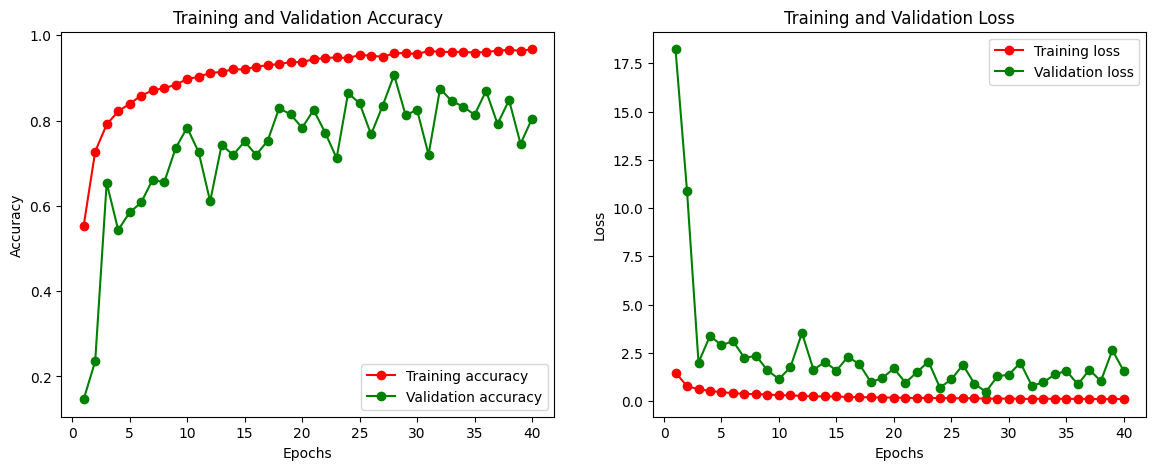

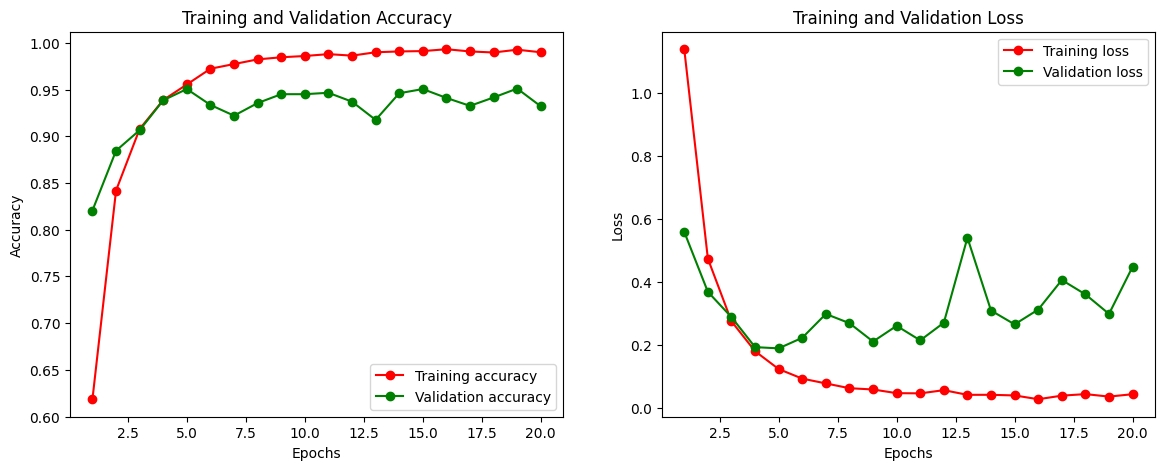

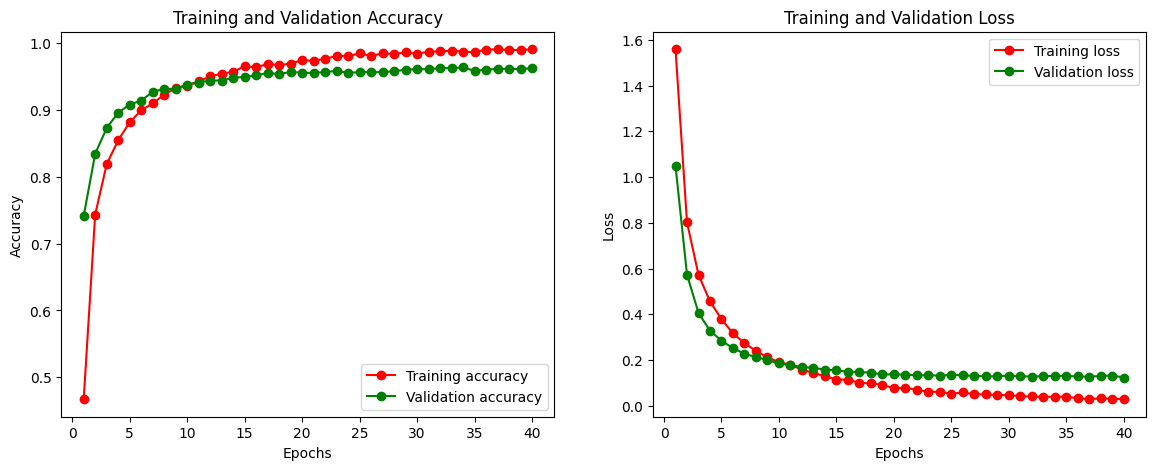

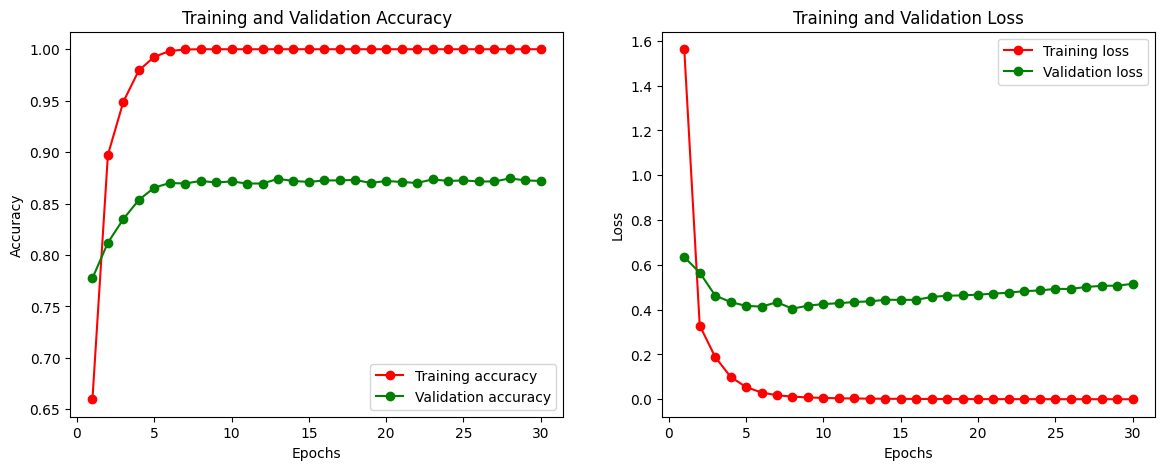

In [30]:
for i in [my_model_history,vgg_history,DenseNet_history,inception_history]:
    performance_graph(i)

In [38]:
histories = {
    'My_model':my_model_history,
    'VGG 16':vgg_history,
    'DenseNet':DenseNet_history,
    'InceptionV3':inception_history
}

results_df = pd.DataFrame(compare_model_results(histories))
results_df

,Model,Final train accuracy,Final validation accuracy,Best validation accuracy
0,My_model,0.967375,0.8045,0.9070
1,VGG 16,0.989875,0.9320,0.9510
2,DenseNet,0.990000,0.9620,0.9630
3,InceptionV3,1.000000,0.8720,0.8745
